In [1]:
import os
import shutil
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

2024-09-06 23:44:10.202550: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-06 23:44:10.253097: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-06 23:44:10.961915: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

In [3]:
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

In [4]:
# Define paths
base_dir = '/home/user/GPU_CSE/Kirti/Dataset_for_Code_Development/Dataset_for_5_classes_by_Sir/ResNet50'
dataset_dir = '/home/user/GPU_CSE/Kirti/Dataset_for_Code_Development/Dataset_for_5_classes_by_Sir/clean_train_partition'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [5]:
# Parameters
img_height, img_width = 224, 224  # ResNet50 requires images of size 224x224
batch_size = 32
num_classes = len(next(os.walk(dataset_dir))[1])  # number of class folders
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

In [6]:
# Function to create train, validation, and test splits
def create_splits():
    try:
        if not os.path.exists(train_dir):
            os.makedirs(train_dir)
        if not os.path.exists(validation_dir):
            os.makedirs(validation_dir)
        if not os.path.exists(test_dir):
            os.makedirs(test_dir)
    
        for class_name in os.listdir(dataset_dir):        
            train_class_path = os.path.join(train_dir, class_name)        
            if not os.path.exists(train_class_path):
                os.makedirs(train_class_path)        
            
            test_class_path = os.path.join(test_dir, class_name)        
            if not os.path.exists(test_class_path):
                os.makedirs(test_class_path)        
    
            validation_class_dir = os.path.join(validation_dir, class_name)       
            if not os.path.exists(validation_class_dir):
                os.makedirs(validation_class_dir)        
        
        for class_name in os.listdir(dataset_dir):        
            class_path = os.path.join(dataset_dir, class_name)
            
            if os.path.isdir(class_path):
                images = os.listdir(class_path)
                random.shuffle(images)
                train_split = int(train_ratio * len(images))
                validation_split = int(validation_ratio * len(images))
                
                train_images = images[:train_split]
                validation_images = images[train_split:train_split + validation_split]
                test_images = images[train_split + validation_split:]
    
                for image in train_images:
                    shutil.copy(os.path.join(class_path, image), os.path.join(train_dir, class_name, image))
                for image in validation_images:
                    shutil.copy(os.path.join(class_path, image), os.path.join(validation_dir, class_name, image))
                for image in test_images:
                    shutil.copy(os.path.join(class_path, image), os.path.join(test_dir, class_name, image))
    except Exception as err:
        print("Error:", str(err))

In [7]:
# Split the dataset
create_splits()

In [8]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.8, 1.2)
)

In [9]:
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1398 images belonging to 5 classes.
Found 429 images belonging to 5 classes.
Found 446 images belonging to 5 classes.


In [11]:
# Load the ResNet50 model pretrained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_1.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

2024-09-06 23:44:13.196385: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46311 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:86:00.0, compute capability: 8.6


In [12]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50


2024-09-06 23:44:19.612450: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2024-09-06 23:44:19.854568: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-09-06 23:44:20.312580: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7eee35031c90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-06 23:44:20.312610: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-09-06 23:44:20.319464: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-06 23:44:20.479571: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

43/43 [==============================] - ETA: 0s - loss: 1.6615 - accuracy: 0.2182

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


43/43 [==============================] - 24s 440ms/step - loss: 1.6615 - accuracy: 0.2182 - val_loss: 1.6630 - val_accuracy: 0.1875
Epoch 2/50
43/43 [==============================] - 18s 423ms/step - loss: 1.6285 - accuracy: 0.2313 - val_loss: 1.6485 - val_accuracy: 0.1803
Epoch 3/50
43/43 [==============================] - 18s 417ms/step - loss: 1.6088 - accuracy: 0.2328 - val_loss: 1.6231 - val_accuracy: 0.2139
Epoch 4/50
43/43 [==============================] - 18s 415ms/step - loss: 1.6123 - accuracy: 0.2262 - val_loss: 1.6168 - val_accuracy: 0.2163
Epoch 5/50
43/43 [==============================] - 18s 416ms/step - loss: 1.6103 - accuracy: 0.2540 - val_loss: 1.6076 - val_accuracy: 0.2091
Epoch 6/50
43/43 [==============================] - 18s 423ms/step - loss: 1.5992 - accuracy: 0.2526 - val_loss: 1.6073 - val_accuracy: 0.2428
Epoch 7/50
43/43 [==============================] - 18s 424ms/step - loss: 1.6122 - accuracy: 0.2496 - val_loss: 1.6049 - val_accuracy: 0.2668
Epoch 8/50

In [13]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

14/14 [==============================] - 2s 109ms/step - loss: 1.5930 - accuracy: 0.2713
Test accuracy: 0.27


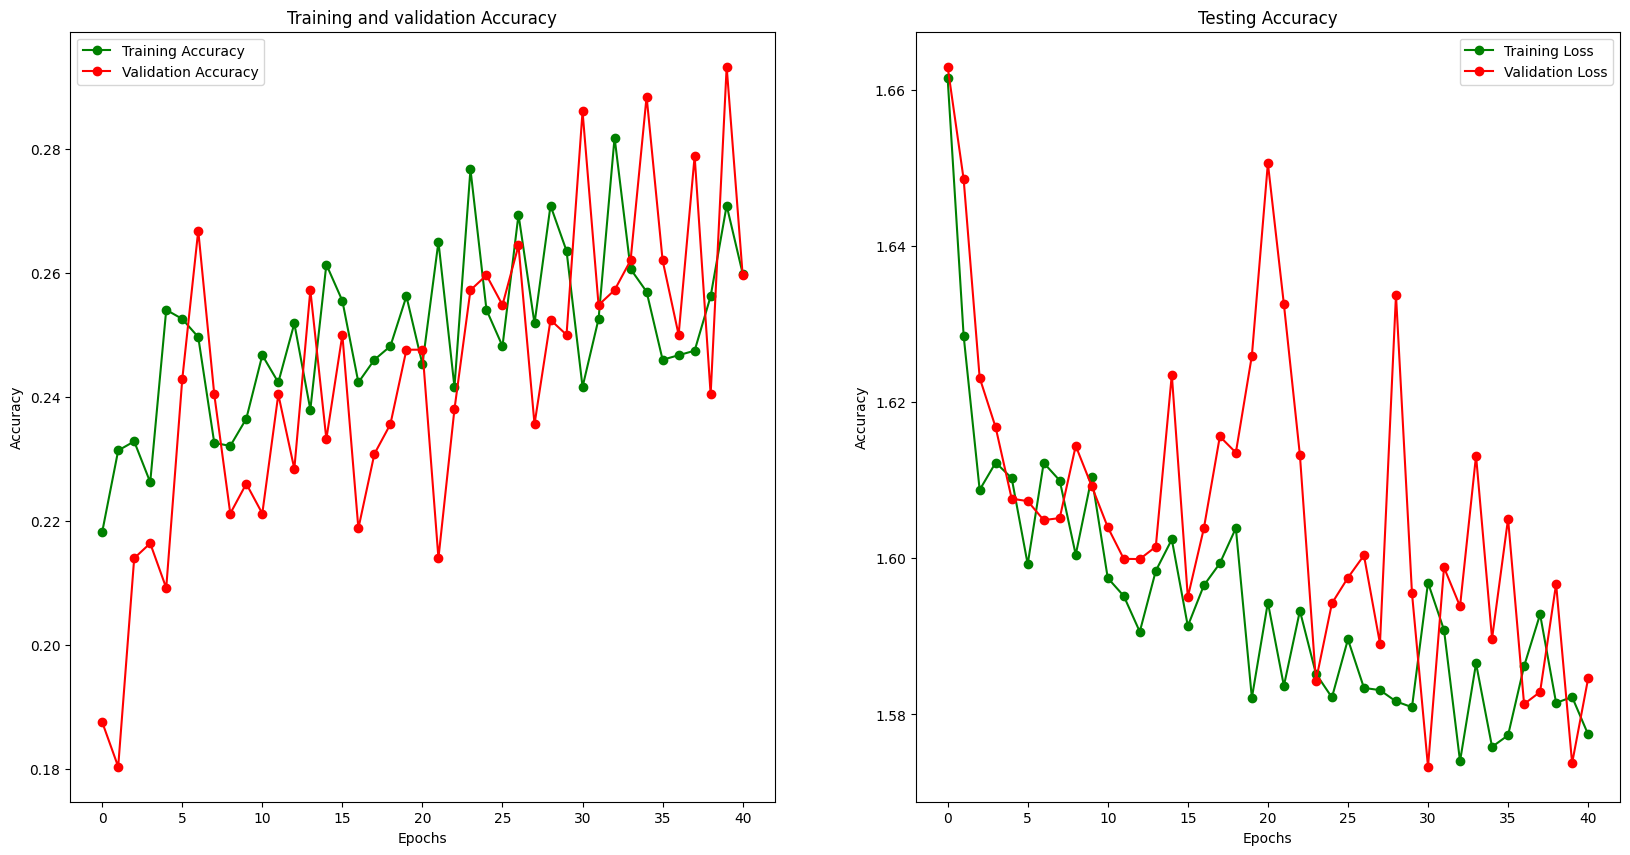

In [14]:
epochs = [i for i in range(len(history.epoch))]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

14/14 [==============================] - 2s 71ms/step


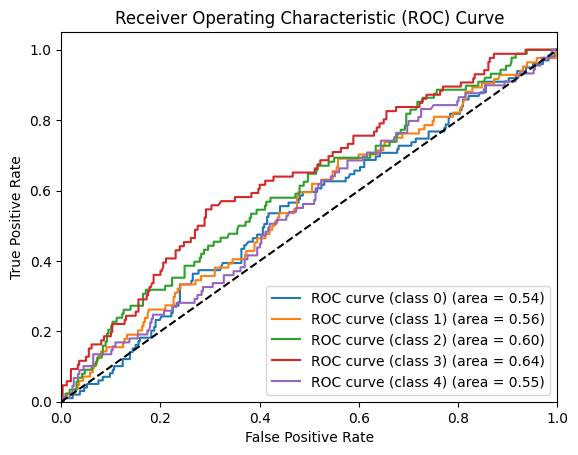

In [15]:
from sklearn.metrics import roc_curve, auc
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Metric Report Calculation for Architecture No 1 

In [16]:
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred_classes: {len(y_pred_classes)}')

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
f2 = fbeta_score(y_true, y_pred_classes, beta=2, average='weighted')

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'F2 Score: {f2:.2f}')

14/14 [==============================] - 1s 94ms/step
Length of y_true: 429
Length of y_pred_classes: 429
Accuracy: 0.23
Precision: 0.23
Recall: 0.23
F1 Score: 0.21
F2 Score: 0.22


In [17]:
# Average AUC Calculations
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred: {len(y_pred)}')

# Binarize the true labels
y_true_binarized = label_binarize(y_true, classes=range(train_generator.num_classes))

# Calculate AUC for each class
auc_scores = []
for i in range(train_generator.num_classes):
    auc = roc_auc_score(y_true_binarized[:, i], y_pred[:, i])
    auc_scores.append(auc)

# Calculate the average AUC
average_auc = np.mean(auc_scores)
print(f'Average AUC: {average_auc:.2f}')

14/14 [==============================] - 1s 69ms/step
Length of y_true: 429
Length of y_pred: 429
Average AUC: 0.49


# Architecture No 2

In [18]:
# Load the ResNet50 model pretrained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-2:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_2.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [19]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
43/43 [==============================] - ETA: 0s - loss: 1.6417 - accuracy: 0.2064

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


43/43 [==============================] - 23s 440ms/step - loss: 1.6417 - accuracy: 0.2064 - val_loss: 1.6713 - val_accuracy: 0.2067
Epoch 2/50
43/43 [==============================] - 18s 418ms/step - loss: 1.6170 - accuracy: 0.2247 - val_loss: 1.6521 - val_accuracy: 0.1779
Epoch 3/50
43/43 [==============================] - 18s 421ms/step - loss: 1.6174 - accuracy: 0.2313 - val_loss: 1.6305 - val_accuracy: 0.1923
Epoch 4/50
43/43 [==============================] - 18s 415ms/step - loss: 1.6033 - accuracy: 0.2445 - val_loss: 1.6244 - val_accuracy: 0.1995
Epoch 5/50
43/43 [==============================] - 18s 426ms/step - loss: 1.5941 - accuracy: 0.2511 - val_loss: 1.6164 - val_accuracy: 0.1923
Epoch 6/50
43/43 [==============================] - 18s 423ms/step - loss: 1.6040 - accuracy: 0.2489 - val_loss: 1.6135 - val_accuracy: 0.2043
Epoch 7/50
43/43 [==============================] - 18s 408ms/step - loss: 1.6052 - accuracy: 0.2321 - val_loss: 1.6155 - val_accuracy: 0.1923
Epoch 8/50

In [20]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

14/14 [==============================] - 1s 90ms/step - loss: 1.5753 - accuracy: 0.2668
Test accuracy: 0.27


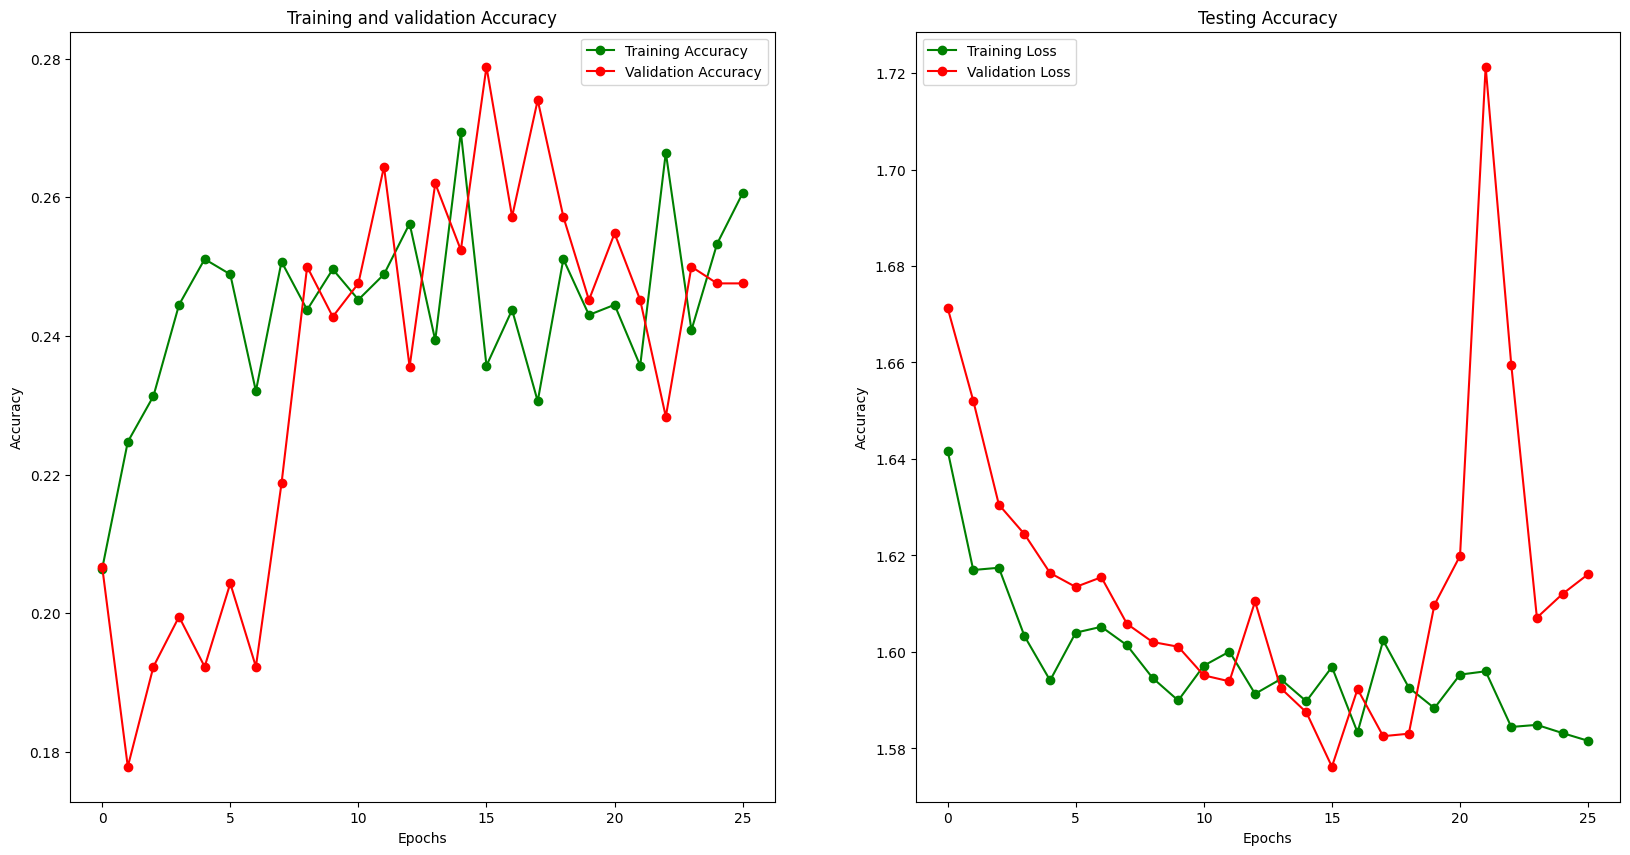

In [21]:
epochs = [i for i in range(len(history.epoch))]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

14/14 [==============================] - 2s 81ms/step


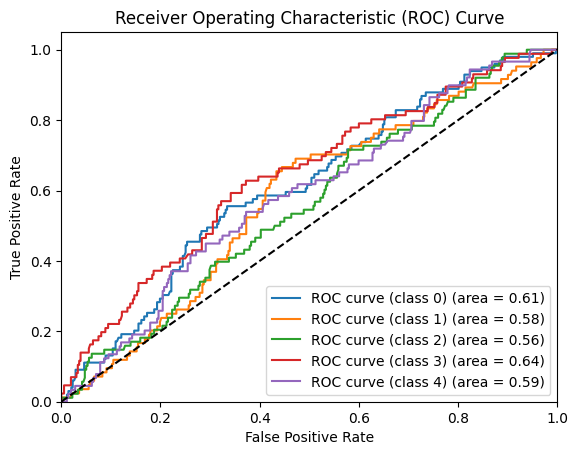

In [22]:
from sklearn.metrics import roc_curve, auc
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Metric Report Calculations for Architecture No 2 

In [23]:
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred_classes: {len(y_pred_classes)}')

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
f2 = fbeta_score(y_true, y_pred_classes, beta=2, average='weighted')

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'F2 Score: {f2:.2f}')

14/14 [==============================] - 1s 73ms/step
Length of y_true: 429
Length of y_pred_classes: 429
Accuracy: 0.22
Precision: 0.21
Recall: 0.22
F1 Score: 0.21
F2 Score: 0.21


In [24]:
# Average AUC Calculations
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred: {len(y_pred)}')

# Binarize the true labels
y_true_binarized = label_binarize(y_true, classes=range(train_generator.num_classes))

# Calculate AUC for each class
auc_scores = []
for i in range(train_generator.num_classes):
    auc = roc_auc_score(y_true_binarized[:, i], y_pred[:, i])
    auc_scores.append(auc)

# Calculate the average AUC
average_auc = np.mean(auc_scores)
print(f'Average AUC: {average_auc:.2f}')

14/14 [==============================] - 1s 79ms/step
Length of y_true: 429
Length of y_pred: 429
Average AUC: 0.49


# Architecture No 4

In [25]:
# Load the ResNet50 model pretrained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-3:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_4.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [26]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
43/43 [==============================] - ETA: 0s - loss: 1.7227 - accuracy: 0.2233

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


43/43 [==============================] - 22s 426ms/step - loss: 1.7227 - accuracy: 0.2233 - val_loss: 1.7287 - val_accuracy: 0.2236
Epoch 2/50
43/43 [==============================] - 18s 421ms/step - loss: 1.6725 - accuracy: 0.2306 - val_loss: 1.6828 - val_accuracy: 0.1851
Epoch 3/50
43/43 [==============================] - 18s 420ms/step - loss: 1.6625 - accuracy: 0.2387 - val_loss: 1.6573 - val_accuracy: 0.1947
Epoch 4/50
43/43 [==============================] - 18s 409ms/step - loss: 1.6442 - accuracy: 0.2313 - val_loss: 1.6699 - val_accuracy: 0.1755
Epoch 5/50
43/43 [==============================] - 18s 426ms/step - loss: 1.6384 - accuracy: 0.2423 - val_loss: 1.6223 - val_accuracy: 0.2163
Epoch 6/50
43/43 [==============================] - 18s 424ms/step - loss: 1.6469 - accuracy: 0.2460 - val_loss: 1.6156 - val_accuracy: 0.2500
Epoch 7/50
43/43 [==============================] - 18s 407ms/step - loss: 1.6328 - accuracy: 0.2548 - val_loss: 1.6163 - val_accuracy: 0.2524
Epoch 8/50

In [27]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

14/14 [==============================] - 1s 78ms/step - loss: 1.5963 - accuracy: 0.2556
Test accuracy: 0.26


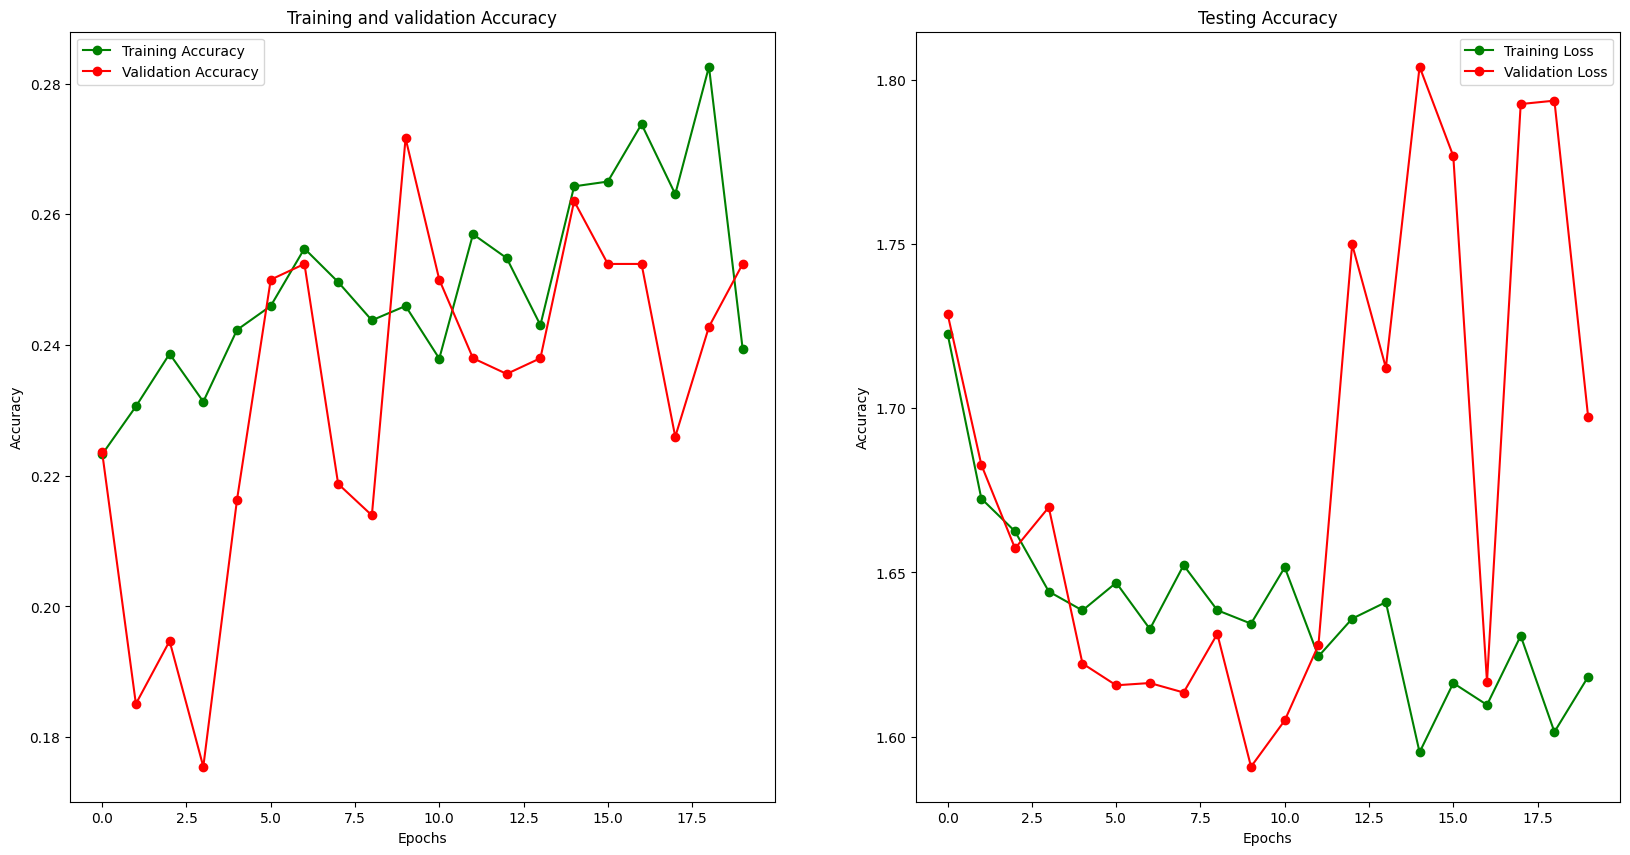

In [28]:
epochs = [i for i in range(len(history.epoch))]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

14/14 [==============================] - 1s 78ms/step


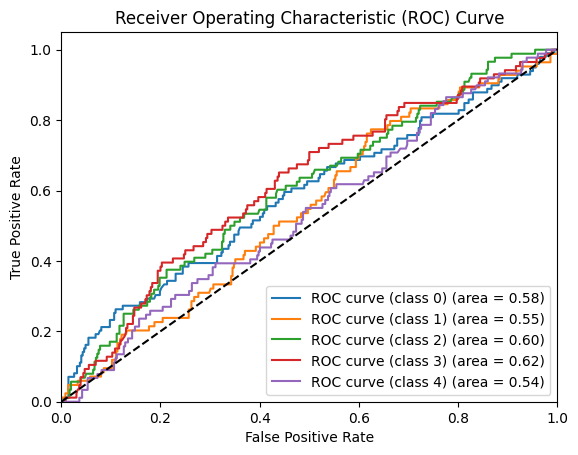

In [30]:
from sklearn.metrics import roc_curve, auc
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

## Metric Report Calculations for Architecture No 4 

In [31]:
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred_classes: {len(y_pred_classes)}')

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
f2 = fbeta_score(y_true, y_pred_classes, beta=2, average='weighted')

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'F2 Score: {f2:.2f}')

14/14 [==============================] - 1s 83ms/step
Length of y_true: 429
Length of y_pred_classes: 429
Accuracy: 0.21
Precision: 0.15
Recall: 0.21
F1 Score: 0.14
F2 Score: 0.17


In [32]:
# Average AUC Calculations
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred: {len(y_pred)}')

# Binarize the true labels
y_true_binarized = label_binarize(y_true, classes=range(train_generator.num_classes))

# Calculate AUC for each class
auc_scores = []
for i in range(train_generator.num_classes):
    auc = roc_auc_score(y_true_binarized[:, i], y_pred[:, i])
    auc_scores.append(auc)

# Calculate the average AUC
average_auc = np.mean(auc_scores)
print(f'Average AUC: {average_auc:.2f}')

14/14 [==============================] - 1s 75ms/step
Length of y_true: 429
Length of y_pred: 429
Average AUC: 0.47


# Architecture No 5

In [33]:
# Load the ResNet50 model pretrained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-4:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_5.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [34]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/50
43/43 [==============================] - ETA: 0s - loss: 1.7497 - accuracy: 0.2299

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


43/43 [==============================] - 24s 440ms/step - loss: 1.7497 - accuracy: 0.2299 - val_loss: 1.6642 - val_accuracy: 0.1971
Epoch 2/50
43/43 [==============================] - 18s 417ms/step - loss: 1.7019 - accuracy: 0.2372 - val_loss: 1.6718 - val_accuracy: 0.2043
Epoch 3/50
43/43 [==============================] - 19s 431ms/step - loss: 1.6816 - accuracy: 0.2343 - val_loss: 1.6472 - val_accuracy: 0.2091
Epoch 4/50
43/43 [==============================] - 18s 413ms/step - loss: 1.6750 - accuracy: 0.2365 - val_loss: 1.6884 - val_accuracy: 0.2043
Epoch 5/50
43/43 [==============================] - 18s 415ms/step - loss: 1.6780 - accuracy: 0.2416 - val_loss: 1.6591 - val_accuracy: 0.2043
Epoch 6/50
43/43 [==============================] - 18s 415ms/step - loss: 1.6789 - accuracy: 0.2423 - val_loss: 1.6712 - val_accuracy: 0.2139
Epoch 7/50
43/43 [==============================] - 19s 432ms/step - loss: 1.6494 - accuracy: 0.2438 - val_loss: 1.6076 - val_accuracy: 0.2476
Epoch 8/50

In [35]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

14/14 [==============================] - 1s 78ms/step - loss: 1.6132 - accuracy: 0.2422
Test accuracy: 0.24


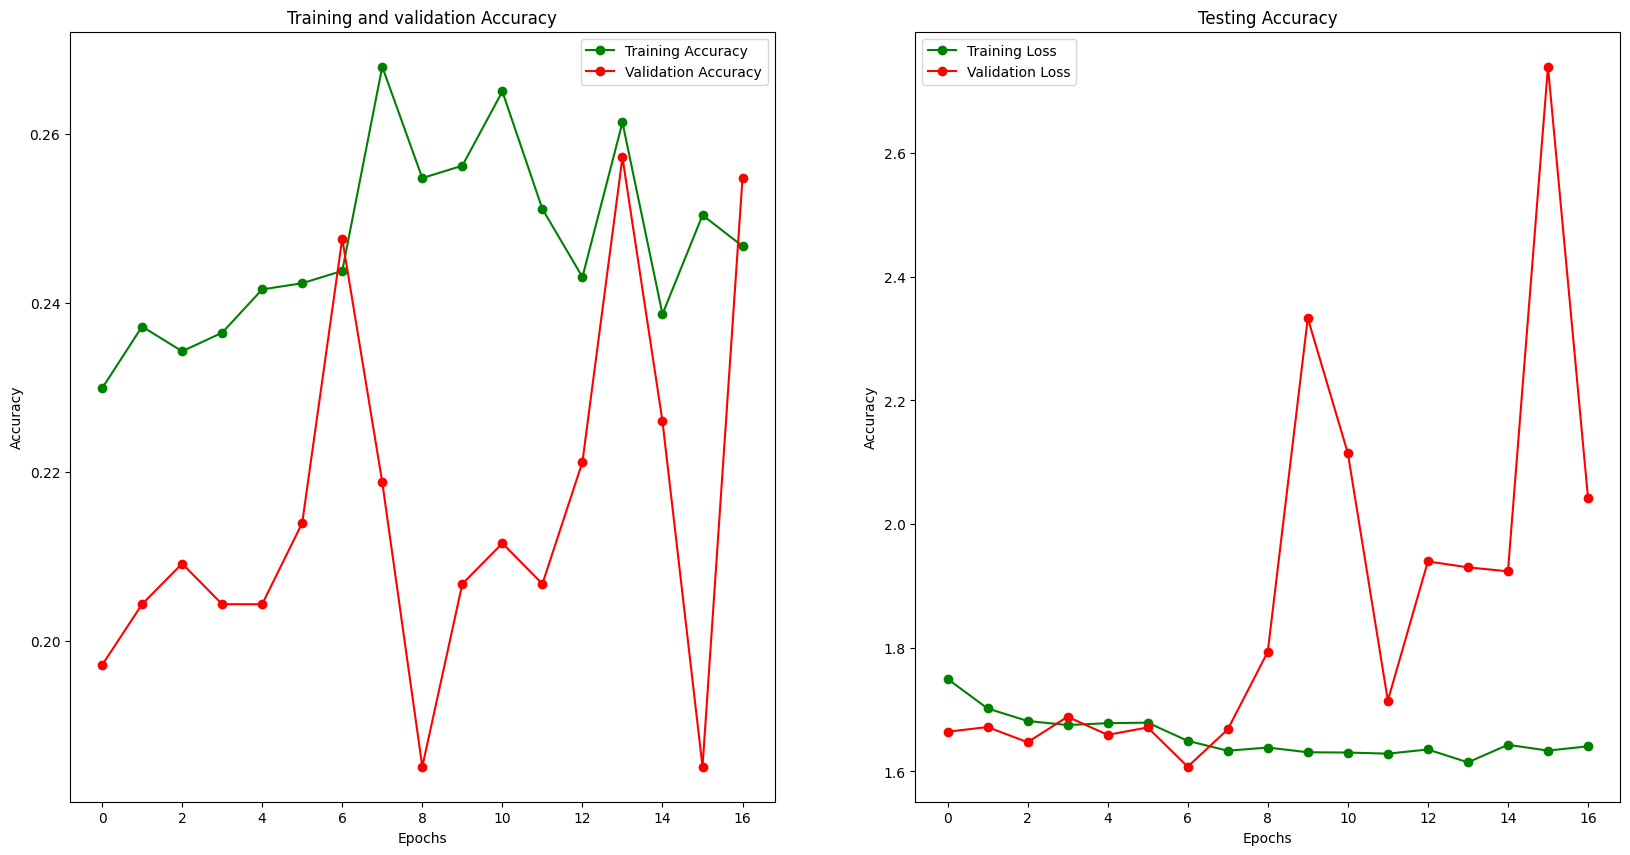

In [36]:
epochs = [i for i in range(len(history.epoch))]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

14/14 [==============================] - 2s 76ms/step


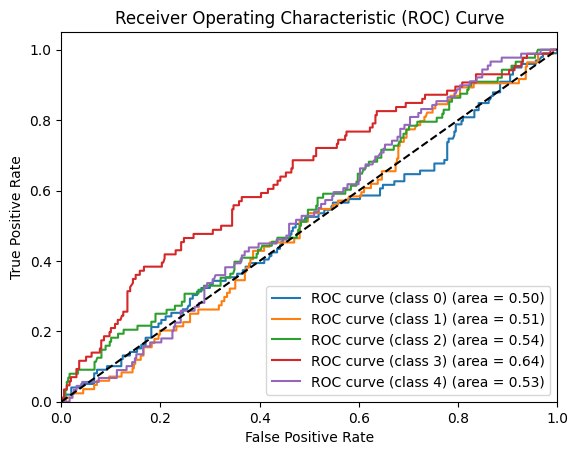

In [37]:
from sklearn.metrics import roc_curve, auc
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Metric Report Calculations for Architecture No 5 

In [38]:
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred_classes: {len(y_pred_classes)}')

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
f2 = fbeta_score(y_true, y_pred_classes, beta=2, average='weighted')

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'F2 Score: {f2:.2f}')

14/14 [==============================] - 1s 78ms/step
Length of y_true: 429
Length of y_pred_classes: 429
Accuracy: 0.18
Precision: 0.18
Recall: 0.18
F1 Score: 0.14
F2 Score: 0.16


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
# Average AUC Calculations
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred: {len(y_pred)}')

# Binarize the true labels
y_true_binarized = label_binarize(y_true, classes=range(train_generator.num_classes))

# Calculate AUC for each class
auc_scores = []
for i in range(train_generator.num_classes):
    auc = roc_auc_score(y_true_binarized[:, i], y_pred[:, i])
    auc_scores.append(auc)

# Calculate the average AUC
average_auc = np.mean(auc_scores)
print(f'Average AUC: {average_auc:.2f}')

14/14 [==============================] - 1s 74ms/step
Length of y_true: 429
Length of y_pred: 429
Average AUC: 0.49


# Architecture No 6

In [40]:
# Load the ResNet50 model pretrained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-4:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
top_model = Dropout(0.3)(top_model)
top_model = Dense(64, activation='relu', name = 'Dense_64')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_6.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [41]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
43/43 [==============================] - ETA: 0s - loss: 1.7546 - accuracy: 0.2094

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


43/43 [==============================] - 24s 446ms/step - loss: 1.7546 - accuracy: 0.2094 - val_loss: 1.6326 - val_accuracy: 0.1971
Epoch 2/50
43/43 [==============================] - 19s 433ms/step - loss: 1.6735 - accuracy: 0.2343 - val_loss: 1.6209 - val_accuracy: 0.2236
Epoch 3/50
43/43 [==============================] - 18s 418ms/step - loss: 1.6582 - accuracy: 0.2379 - val_loss: 1.6212 - val_accuracy: 0.1971
Epoch 4/50
43/43 [==============================] - 19s 431ms/step - loss: 1.6519 - accuracy: 0.2467 - val_loss: 1.6140 - val_accuracy: 0.2139
Epoch 5/50
43/43 [==============================] - 19s 432ms/step - loss: 1.6412 - accuracy: 0.2467 - val_loss: 1.6069 - val_accuracy: 0.2236
Epoch 6/50
43/43 [==============================] - 18s 417ms/step - loss: 1.6383 - accuracy: 0.2456 - val_loss: 1.6149 - val_accuracy: 0.1851
Epoch 7/50
43/43 [==============================] - 19s 437ms/step - loss: 1.6644 - accuracy: 0.2343 - val_loss: 1.6052 - val_accuracy: 0.2019
Epoch 8/50

In [42]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

14/14 [==============================] - 1s 74ms/step - loss: 1.6020 - accuracy: 0.1996
Test accuracy: 0.20


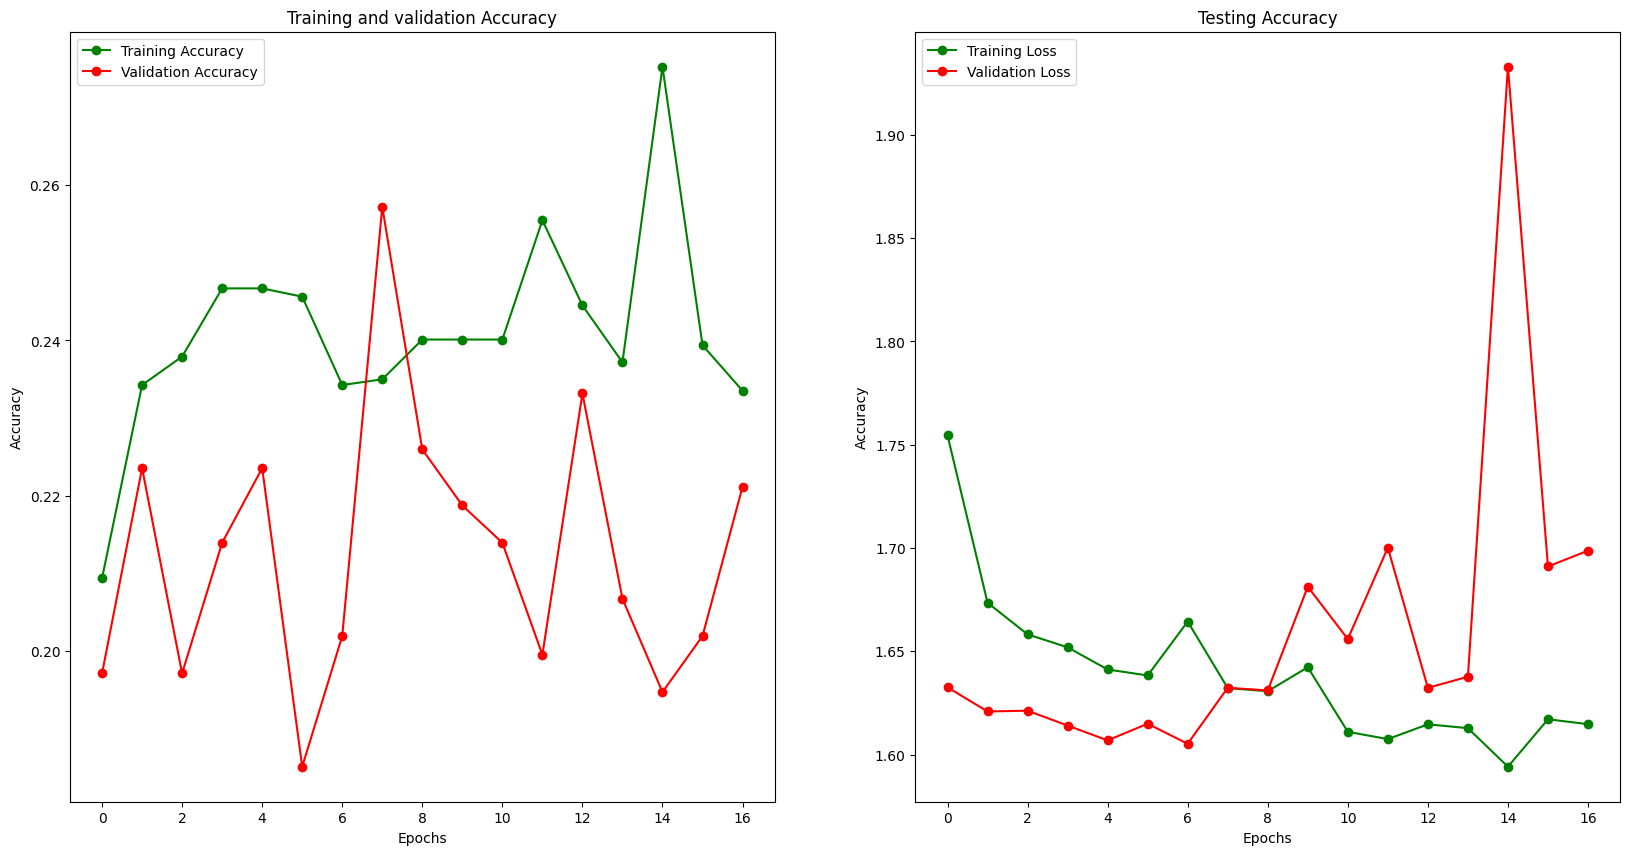

In [43]:
epochs = [i for i in range(len(history.epoch))]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

14/14 [==============================] - 2s 75ms/step


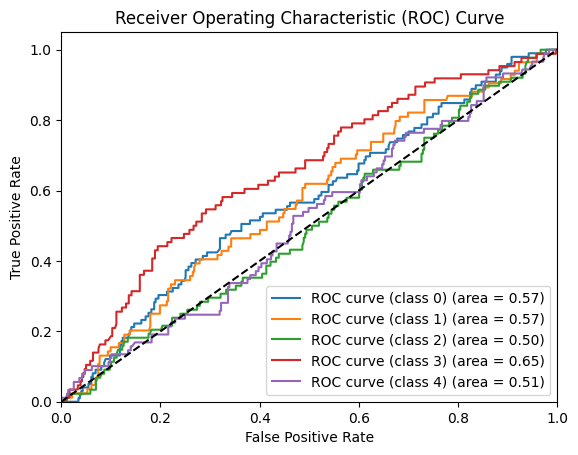

In [44]:
from sklearn.metrics import roc_curve, auc
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Metric Report Calculation for Architecture No 6 

In [45]:
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred_classes: {len(y_pred_classes)}')

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
f2 = fbeta_score(y_true, y_pred_classes, beta=2, average='weighted')

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'F2 Score: {f2:.2f}')

14/14 [==============================] - 1s 68ms/step
Length of y_true: 429
Length of y_pred_classes: 429
Accuracy: 0.19
Precision: 0.14
Recall: 0.19
F1 Score: 0.13
F2 Score: 0.15


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
# Average AUC Calculations
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred: {len(y_pred)}')

# Binarize the true labels
y_true_binarized = label_binarize(y_true, classes=range(train_generator.num_classes))

# Calculate AUC for each class
auc_scores = []
for i in range(train_generator.num_classes):
    auc = roc_auc_score(y_true_binarized[:, i], y_pred[:, i])
    auc_scores.append(auc)

# Calculate the average AUC
average_auc = np.mean(auc_scores)
print(f'Average AUC: {average_auc:.2f}')

14/14 [==============================] - 1s 73ms/step
Length of y_true: 429
Length of y_pred: 429
Average AUC: 0.51


# Architecture No 7

In [47]:
# Load the ResNet50 model pretrained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-4:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(2048, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(1024, activation='relu', name = 'Dense_512')(top_model)
top_model = Dropout(0.3)(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_64')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_7.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [48]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
43/43 [==============================] - ETA: 0s - loss: 1.7465 - accuracy: 0.2035

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


43/43 [==============================] - 24s 440ms/step - loss: 1.7465 - accuracy: 0.2035 - val_loss: 1.6121 - val_accuracy: 0.2236
Epoch 2/50
43/43 [==============================] - 18s 429ms/step - loss: 1.7055 - accuracy: 0.2167 - val_loss: 1.6090 - val_accuracy: 0.2043
Epoch 3/50
43/43 [==============================] - 19s 434ms/step - loss: 1.7073 - accuracy: 0.2138 - val_loss: 1.6051 - val_accuracy: 0.2356
Epoch 4/50
43/43 [==============================] - 18s 409ms/step - loss: 1.6675 - accuracy: 0.2255 - val_loss: 1.6114 - val_accuracy: 0.2163
Epoch 5/50
43/43 [==============================] - 18s 417ms/step - loss: 1.7127 - accuracy: 0.2204 - val_loss: 1.6188 - val_accuracy: 0.2236
Epoch 6/50
43/43 [==============================] - 18s 415ms/step - loss: 1.6849 - accuracy: 0.2350 - val_loss: 1.6099 - val_accuracy: 0.2500
Epoch 7/50
43/43 [==============================] - 18s 418ms/step - loss: 1.6805 - accuracy: 0.2460 - val_loss: 1.6159 - val_accuracy: 0.2115
Epoch 8/50

In [49]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

14/14 [==============================] - 1s 74ms/step - loss: 1.5918 - accuracy: 0.2422
Test accuracy: 0.24


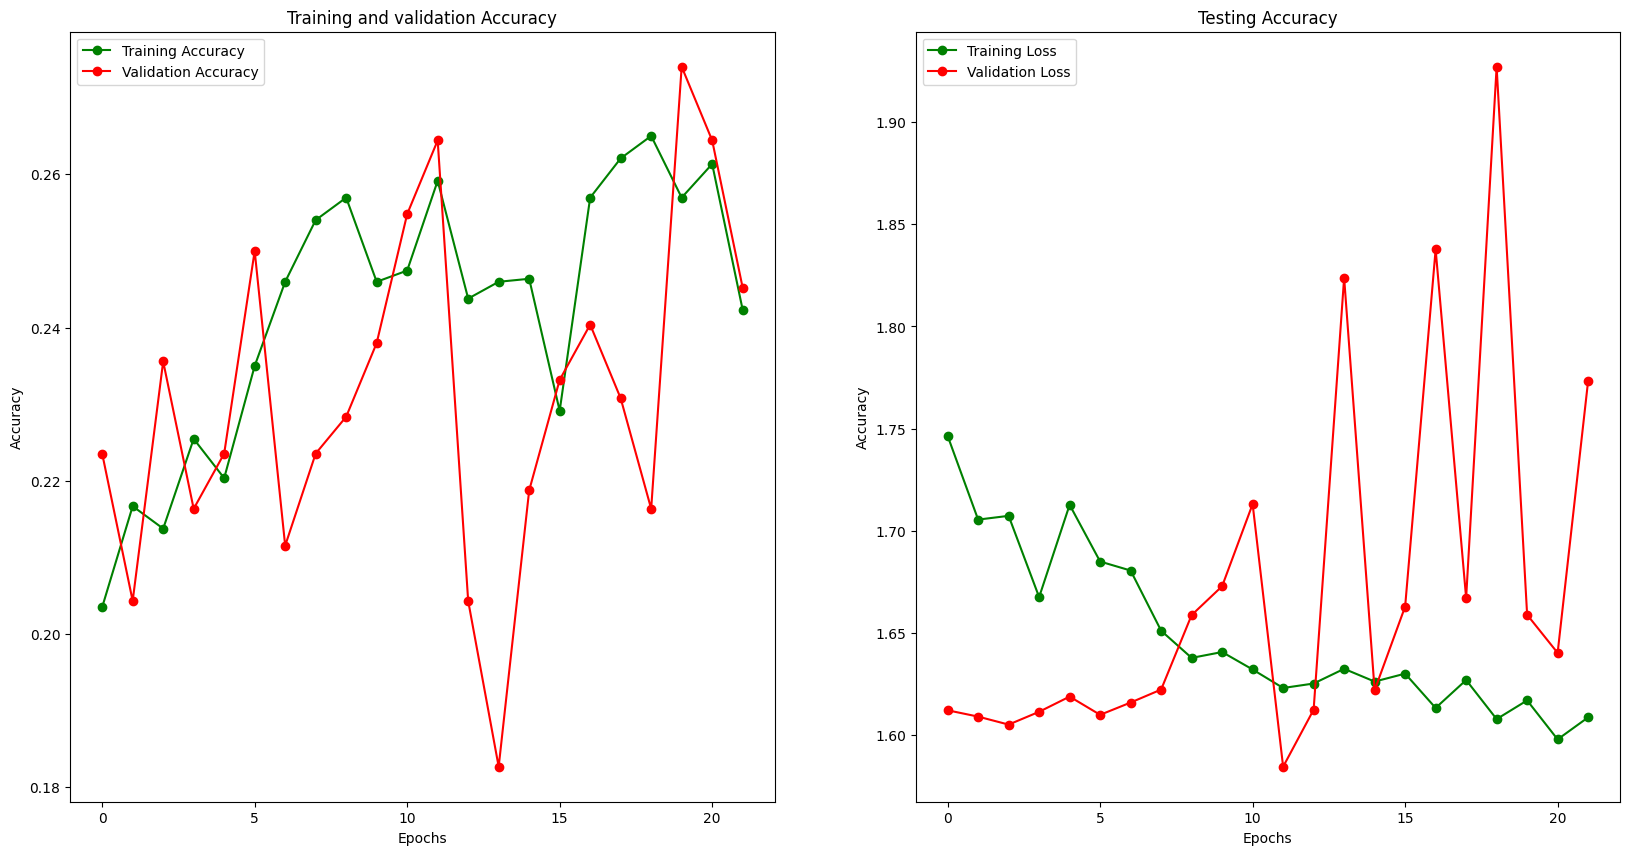

In [50]:
epochs = [i for i in range(len(history.epoch))]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

14/14 [==============================] - 2s 78ms/step


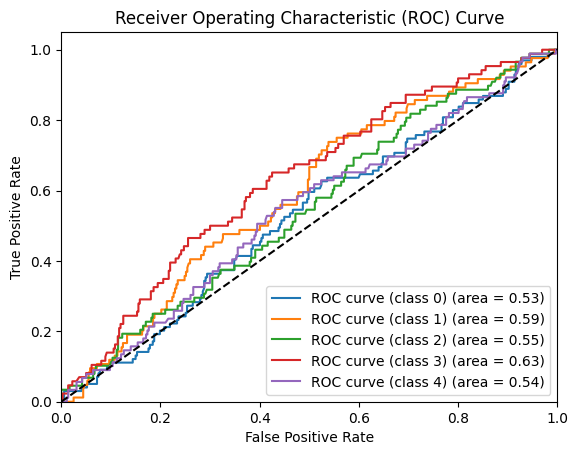

In [51]:
from sklearn.metrics import roc_curve, auc
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## Metric Report Calculations for Architecture No 7 

In [52]:
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred_classes: {len(y_pred_classes)}')

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
f2 = fbeta_score(y_true, y_pred_classes, beta=2, average='weighted')

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'F2 Score: {f2:.2f}')

14/14 [==============================] - 1s 71ms/step
Length of y_true: 429
Length of y_pred_classes: 429
Accuracy: 0.20
Precision: 0.16
Recall: 0.20
F1 Score: 0.17
F2 Score: 0.18


In [53]:
# Average AUC Calculations
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred: {len(y_pred)}')

# Binarize the true labels
y_true_binarized = label_binarize(y_true, classes=range(train_generator.num_classes))

# Calculate AUC for each class
auc_scores = []
for i in range(train_generator.num_classes):
    auc = roc_auc_score(y_true_binarized[:, i], y_pred[:, i])
    auc_scores.append(auc)

# Calculate the average AUC
average_auc = np.mean(auc_scores)
print(f'Average AUC: {average_auc:.2f}')

14/14 [==============================] - 1s 76ms/step
Length of y_true: 429
Length of y_pred: 429
Average AUC: 0.50
